In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import pandas as pd
from kloppy import secondspectrum


In [3]:
import sys
 
# setting path
sys.path.append('../')
 
# # importing
from src.second_spectrum_utils import get_home_away_tracking
import src.player_velocities as vel
import src.pitch_control as pc
import src.visualizations as viz

In [4]:
dataset = secondspectrum.load(
    meta_data="../man-city-data/SecondSpectrum/MCI Women_s Files-001/g2312135_SecondSpectrum_meta.xml",
    raw_data="../man-city-data/SecondSpectrum/MCI Women_s Files-001/g2312135_SecondSpectrum_tracking-produced.jsonl",
    
    # Optional arguments
    sample_rate=1/1,
    coordinates="secondspectrum",
    only_alive=False)


In [5]:
home_df, away_df = get_home_away_tracking(dataset)

In [6]:
tracking_home = vel.calc_player_velocities(home_df,smoothing=True,filter_='moving_average')
tracking_away = vel.calc_player_velocities(away_df,smoothing=True,filter_='moving_average')

In [7]:
params=pc.parameters()

In [8]:
df = dataset.to_df()

In [429]:
frame = 15491
attacking_team = df.loc[df.frame_id == frame, "ball_owning_team_id"].item().capitalize()
attacking_team

'Home'

(<Figure size 1200x800 with 2 Axes>, <Axes: >)

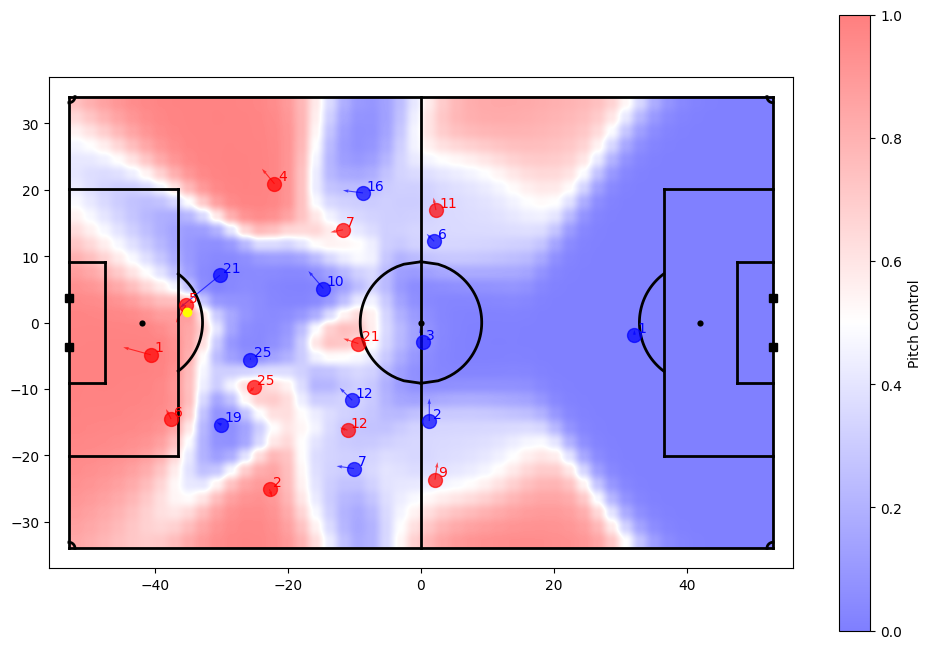

In [430]:
viz.plot_pitch_control_for_frame(frame, tracking_home, tracking_away, attacking_team, params)

(<Figure size 1200x800 with 2 Axes>, <Axes: >)

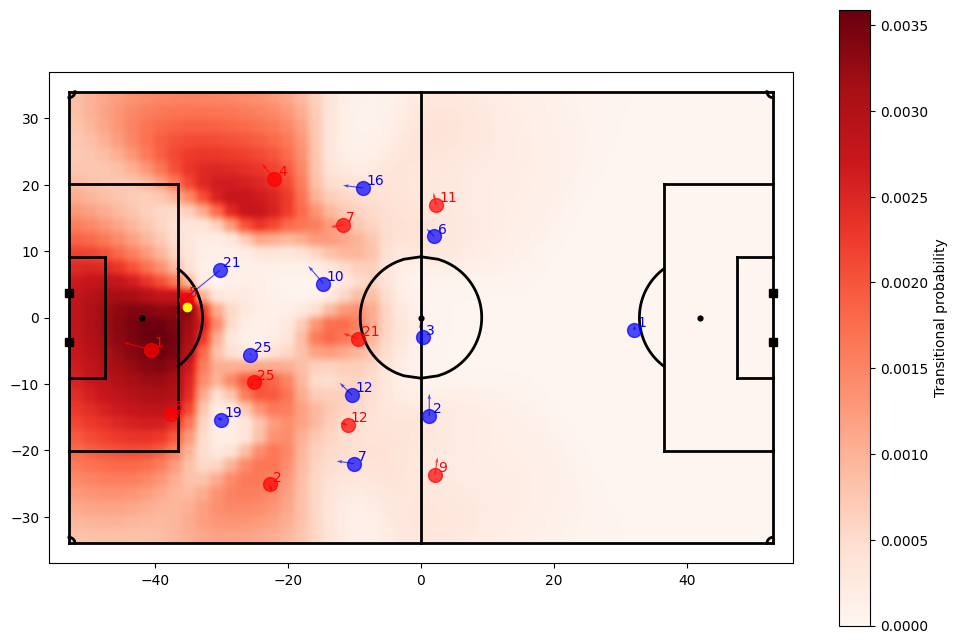

In [431]:
viz.plot_transition_proba_for_frame(frame, tracking_home, tracking_away, attacking_team,params)

(<Figure size 1200x800 with 2 Axes>, <Axes: >)

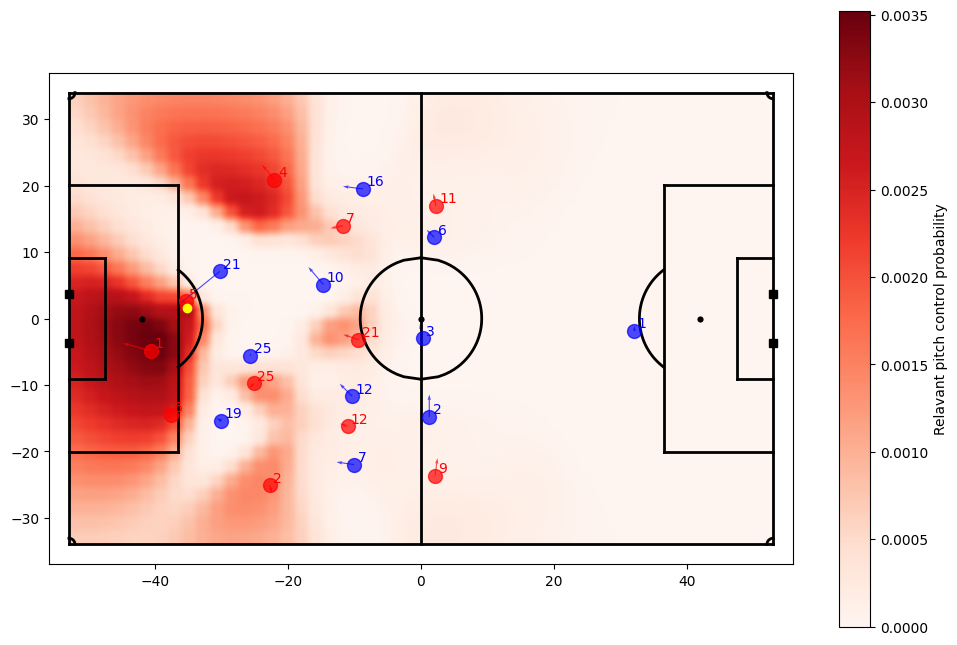

In [432]:
viz.plot_relevant_pitch_for_frame(frame, tracking_home, tracking_away, attacking_team ,params)

0.25745362
0.0063830300000000005


(<Figure size 1200x800 with 2 Axes>, <Axes: >)

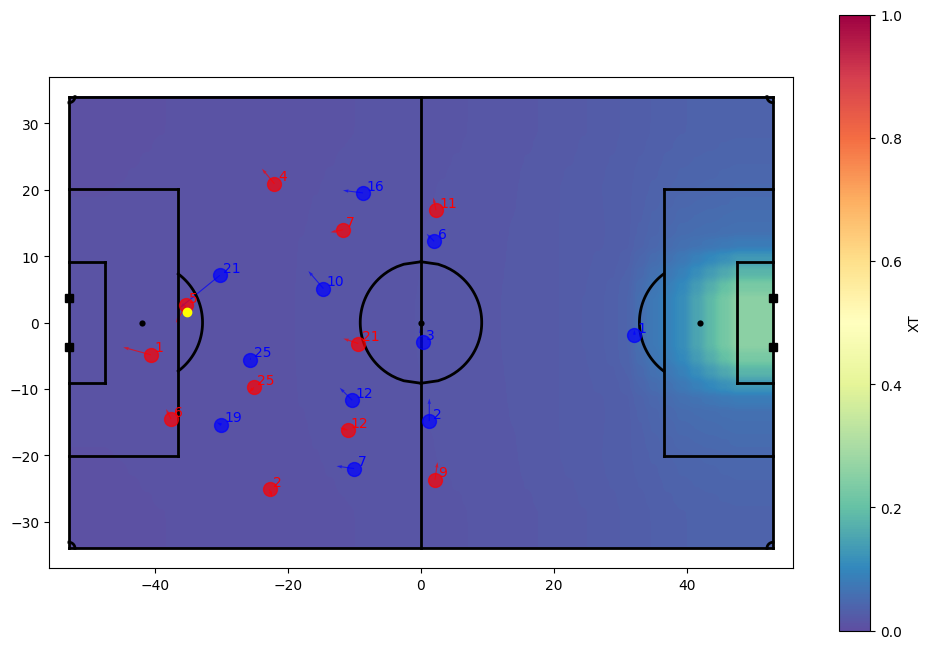

In [433]:
viz.plot_expected_goals_surface_for_frame(frame, tracking_home, tracking_away, attacking_team ,params)

off ball expected threat: 0.7%


(<Figure size 1200x800 with 2 Axes>, <Axes: >)

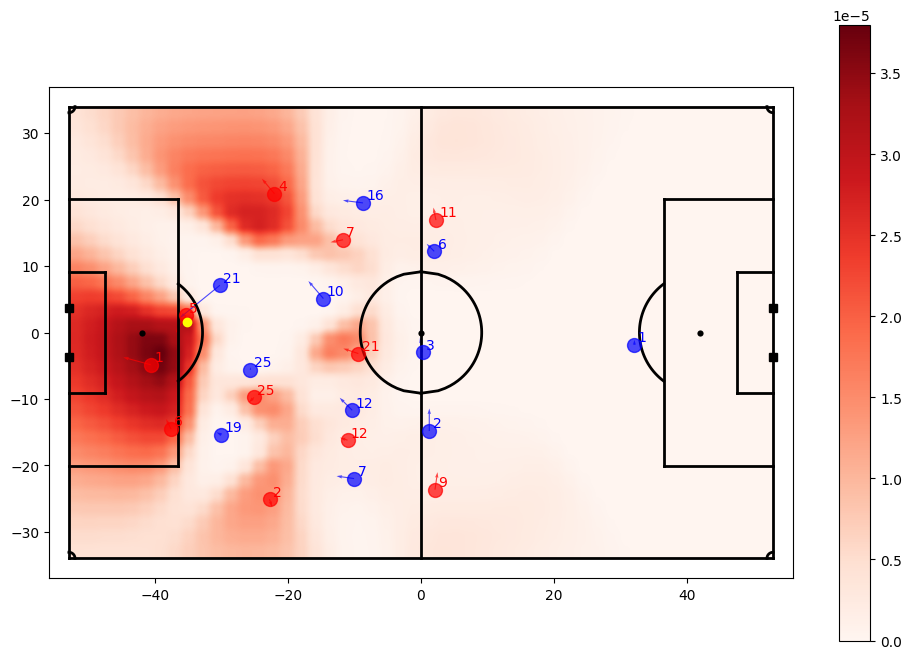

In [573]:
viz.plot_scoring_opp_for_frame(frame, tracking_home, tracking_away, attacking_team, params)

In [26]:
off_scoring, xgrid, ygrid = generate_off_ball_scoring_opportunity_for_frame(frame, tracking_home, tracking_away, attacking_team, params)
str(round(np.sum(off_scoring)*100,1))

'1.7'

In [232]:
dataset = secondspectrum.load(
    meta_data="../man-city-data/SecondSpectrum/MCI Women_s Files-001/g2312135_SecondSpectrum_meta.xml",
    raw_data="../man-city-data/SecondSpectrum/MCI Women_s Files-001/g2312135_SecondSpectrum_tracking-produced.jsonl",
    
    # Optional arguments
    sample_rate=1/25,
    coordinates="secondspectrum",
    only_alive=True)

In [422]:
x = dataset.to_df()

In [428]:
x[(x.ball_owning_team_id == "home") & (x.period_id == 1)].shape

(987, 120)

In [235]:
frames = []
team = []
value = []
time = []
period = []
control_matrix_home_h1 = []
control_matrix_away_h1 = []
control_matrix_home_h2 = []
control_matrix_away_h2 = []
for index, row in x.iterrows():
    attacking_team = row["ball_owning_team_id"].capitalize()
    off_scoring, xgrid, ygrid = generate_off_ball_scoring_opportunity_for_frame(row["frame_id"], tracking_home, tracking_away, attacking_team, params)
    if row["period_id"] == 1:
        control_matrix_home_h1.append(off_scoring) if attacking_team == "Home" else control_matrix_away_h1.append(off_scoring) 
    else:
        control_matrix_home_h2.append(off_scoring) if attacking_team == "Home" else control_matrix_away_h2.append(off_scoring)
    frames.append(row["frame_id"])
    period.append(row["period_id"])
    team.append(attacking_team)
    value.append(round(np.sum(off_scoring)*100,1))
    time.append(row['timestamp'])

In [236]:
import pickle

with open('control_matrix_home_h1.pkl', 'wb') as f:
    pickle.dump(control_matrix_home_h1, f)
with open('control_matrix_away_h1.pkl', 'wb') as f:
    pickle.dump(control_matrix_away_h1, f)
with open('control_matrix_home_h2.pkl', 'wb') as f:
    pickle.dump(control_matrix_home_h2, f)
with open('control_matrix_away_h2.pkl', 'wb') as f:
    pickle.dump(control_matrix_away_h2, f)          

IMPORT LISTS FROM PICKLE FILES HERE

In [316]:
result = np.zeros(control_matrix_home_h1[0].shape)
for matrix in control_matrix_home_h1:
    result += matrix

In [317]:
field_dimen=(106.,68.)
n_grid_cells_y = int(50*field_dimen[1]/field_dimen[0])
xgrid = np.linspace( -field_dimen[0]/2., field_dimen[0]/2., 50)
ygrid = np.linspace( -field_dimen[1]/2., field_dimen[1]/2., n_grid_cells_y )

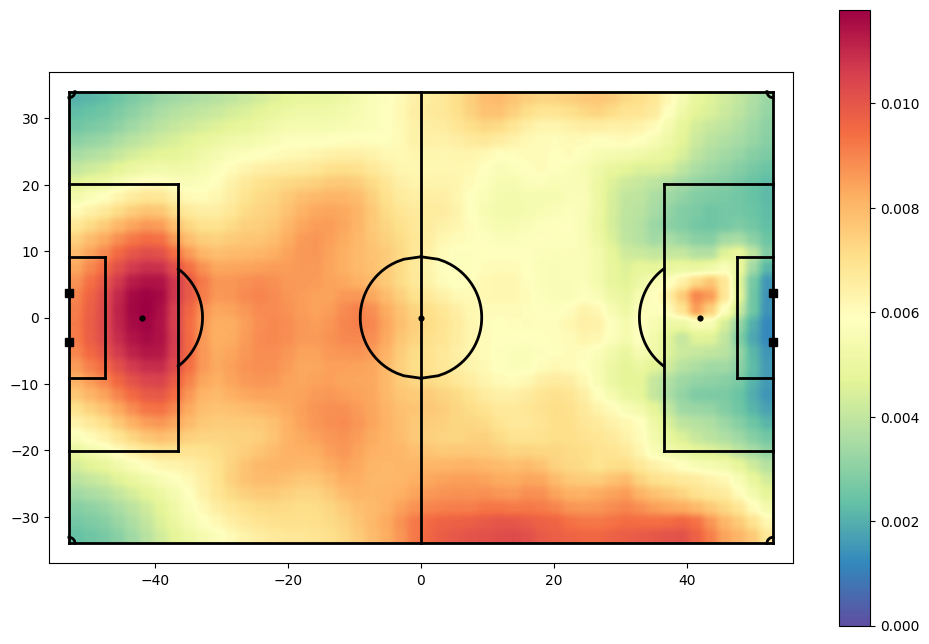

In [418]:
fig,ax = viz.plot_pitch(field_color='white', field_dimen = field_dimen)
im = ax.imshow(np.flipud(result), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,vmax=np.max(result),cmap="Spectral_r")
# Add colorbar
cbar = fig.colorbar(im)

In [237]:
value_df = pd.DataFrame(
    {'frame': frames,
     'team': team,
     'time': time,
     'value': value,
     'period': period
    })

In [437]:
h1 = value_df[(value_df.period == 1) & (value_df.team == "Home")].reset_index()
h1['control_matrix'] = control_matrix_home_h1

,index,frame,team,time,value,period,control_matrix
0,0,1,Home,0.04,1.1,1,"[[6.193567784332041e-07, 7.515962853370417e-07..."
1,1,26,Home,1.04,1.0,1,"[[1.0185724338324216e-06, 1.1930011029144278e-..."
2,2,51,Home,2.04,1.0,1,"[[1.2366484720232091e-06, 1.4427893748727103e-..."
3,3,76,Home,3.04,0.9,1,"[[3.2185394298648663e-06, 3.629354820142226e-0..."
4,4,101,Home,4.04,0.9,1,"[[4.4470366476140595e-06, 4.883035155823629e-0..."
...,...,...,...,...,...,...,...
982,1787,76126,Home,3045.04,1.9,1,"[[2.344484813450339e-08, 3.287788900218976e-08..."
983,1788,76151,Home,3046.04,1.8,1,"[[3.940500150508606e-08, 5.4699516589214956e-0..."
984,1789,76604,Home,3064.16,1.6,1,"[[9.701097902379743e-08, 1.3175870029610028e-0..."
985,1790,76629,Home,3065.16,1.7,1,"[[7.293668252468496e-08, 9.955784388488129e-08..."


In [440]:
h2 = value_df[(value_df.period == 2) & (value_df.team == "Home")].reset_index()
h2['control_matrix'] = control_matrix_home_h2
a1 = value_df[(value_df.period == 1) & (value_df.team == "Away")].reset_index()
a1['control_matrix'] = control_matrix_away_h1
a2 = value_df[(value_df.period == 2) & (value_df.team == "Away")].reset_index()
a2['control_matrix'] = control_matrix_away_h2

In [442]:
df = pd.concat([h1,h2,a1,a2])
df = df.set_index("index")

In [238]:
value_df.to_csv("values_df.csv")

In [571]:
h = value_df[(value_df.period == 1)]

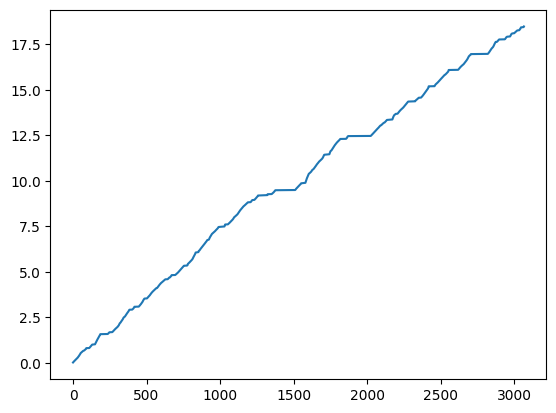

In [572]:
cumulative_sum = h['value'].cumsum()/100

# Create a plot of the cumulative sum
plt.plot(h['time'], cumulative_sum)

In [242]:
h1['xT'] = h1['value'] * h1['team'].apply(lambda x: 1 if x == 'Home' else -1)

In [40]:
for i in value_df.index:
    if i > 119:
        value_df.loc[i, 'time'] += 2700

In [208]:
h2.head()

,frame,team,time,value,period,xT
120,76885,Away,8.72,1.0,2,-1.0
121,77260,Away,23.72,1.4,2,-1.4
122,78131,Home,58.56,1.1,2,1.1
123,78506,Away,73.56,0.7,2,-0.7
124,79281,Away,104.56,0.9,2,-0.9


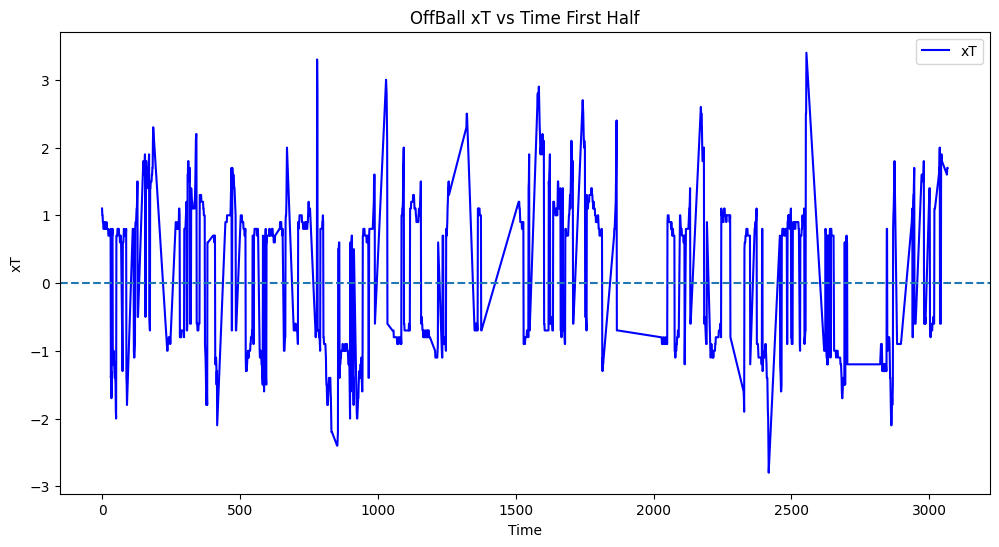

In [243]:
fig, ax = plt.subplots(figsize=(12, 6))

# Create line chart with blue and red colors
h1.plot(x='time', y='xT', kind='line', color='blue', ax=ax)

# Add labels to the chart
plt.xlabel('Time')
plt.ylabel('xT')

# Add x-axis line at xT=0
ax.axhline(y=0, linestyle='--')

plt.title('OffBall xT vs Time First Half')
plt.show()

In [447]:
df.head()

,frame,team,time,value,period,control_matrix
index,,,,,,
0,1,Home,0.04,1.1,1,"[[6.193567784332041e-07, 7.515962853370417e-07..."
1,26,Home,1.04,1.0,1,"[[1.0185724338324216e-06, 1.1930011029144278e-..."
2,51,Home,2.04,1.0,1,"[[1.2366484720232091e-06, 1.4427893748727103e-..."
3,76,Home,3.04,0.9,1,"[[3.2185394298648663e-06, 3.629354820142226e-0..."
4,101,Home,4.04,0.9,1,"[[4.4470366476140595e-06, 4.883035155823629e-0..."


In [444]:
def normalize_dataframe(df):
    json_data = json.loads(df.to_json(orient='records'))
    norm_df = pd.json_normalize(json_data)
    return norm_df

def rename_cols(df):
    new_cols = [i.replace('.', '_') for i in df.columns]
    df.columns = new_cols
    df = df.rename(columns={
        'period': 'period_id',
        'id':'event_id',
    })
    return df

In [446]:
import json
data = pd.read_json("../man-city-data/StatsBomb/Data/ManCity_Arsenal_events.json")
data = rename_cols(normalize_dataframe(data))
data['time'] = data['minute'] * 60 + data['second'] - ((data['period_id'] -1) * 45  * 60 )
data 

,event_id,index,period_id,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,pass_inswinging,foul_committed_card_id,foul_committed_card_name,bad_behaviour_card_id,bad_behaviour_card_name,pass_miscommunication,pass_cut_back,dribble_overrun,pass_outswinging,time
0,5ab3a8e3-e6e1-4a94-b057-57b2301abac5,1,1,1681862400000,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,15347fb5-bd07-47c7-9331-b5d0d6901847,2,1,1681862400000,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,7b3793be-f0aa-40b5-aedf-e2ec45e43069,3,1,1681862400000,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,b3f6b437-6189-49a7-84b3-06992c851d5d,4,1,1681862400000,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,edbc9819-3d24-4c37-adc0-06949261903b,5,1,1681862400280,0,0,2,0.015265,0.007439,0.007826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3624,444d8040-a64f-4d7b-a1ef-11fefd77fe15,3625,2,1681865390497,94,50,192,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2990
3625,e284d714-7d5f-421b-b75d-18dc784a6bcd,3626,2,1681865390497,94,50,192,0.007870,0.005570,0.002300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2990
3626,5eee8f04-dd7a-4d58-9354-7ac8bd05625b,3627,2,1681865390617,94,50,192,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2990
3627,eef577be-b34f-4e69-a0cd-311e7983cb6b,3628,2,1681865394982,94,54,192,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2994


In [449]:
df = df.rename(columns={'period': 'period_id'})


In [457]:
df['time'] = df['time'].apply(np.floor)
df

,frame,team,time,value,period_id,control_matrix
index,,,,,,
0,1,Home,0.0,1.1,1,"[[6.193567784332041e-07, 7.515962853370417e-07..."
1,26,Home,1.0,1.0,1,"[[1.0185724338324216e-06, 1.1930011029144278e-..."
2,51,Home,2.0,1.0,1,"[[1.2366484720232091e-06, 1.4427893748727103e-..."
3,76,Home,3.0,0.9,1,"[[3.2185394298648663e-06, 3.629354820142226e-0..."
4,101,Home,4.0,0.9,1,"[[4.4470366476140595e-06, 4.883035155823629e-0..."
...,...,...,...,...,...,...
3416,151501,Away,2993.0,0.7,2,"[[1.142354126035895e-06, 1.2030127531037598e-0..."
3417,151526,Away,2994.0,0.7,2,"[[9.6923671488305e-07, 1.0085166775867096e-06,..."
3418,151551,Away,2995.0,0.7,2,"[[7.566855776351926e-07, 7.825827444498957e-07..."


In [458]:
merged_df = pd.merge(data, df, on=['period_id', 'time'], how='left')

In [473]:
merged_df.head()

,event_id,index,period_id,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,bad_behaviour_card_name,pass_miscommunication,pass_cut_back,dribble_overrun,pass_outswinging,time,frame,team,value,control_matrix
0,5ab3a8e3-e6e1-4a94-b057-57b2301abac5,1,1,1681862400000,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1.0,Home,1.1,"[[6.193567784332041e-07, 7.515962853370417e-07..."
1,15347fb5-bd07-47c7-9331-b5d0d6901847,2,1,1681862400000,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1.0,Home,1.1,"[[6.193567784332041e-07, 7.515962853370417e-07..."
2,7b3793be-f0aa-40b5-aedf-e2ec45e43069,3,1,1681862400000,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1.0,Home,1.1,"[[6.193567784332041e-07, 7.515962853370417e-07..."
3,b3f6b437-6189-49a7-84b3-06992c851d5d,4,1,1681862400000,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1.0,Home,1.1,"[[6.193567784332041e-07, 7.515962853370417e-07..."
4,edbc9819-3d24-4c37-adc0-06949261903b,5,1,1681862400280,0,0,2,0.015265,0.007439,0.007826,...,NaN,NaN,NaN,NaN,NaN,0,1.0,Home,1.1,"[[6.193567784332041e-07, 7.515962853370417e-07..."


In [482]:
mapped_df = merged_df.copy()
mapped_df.columns

Index(['event_id', 'index', 'period_id', 'timestamp', 'minute', 'second',
       'possession', 'obv_for_after', 'obv_for_before', 'obv_for_net',
       ...
       'bad_behaviour_card_name', 'pass_miscommunication', 'pass_cut_back',
       'dribble_overrun', 'pass_outswinging', 'time', 'frame', 'team', 'value',
       'control_matrix'],
      dtype='object', length=152)

In [483]:
mapped_df

,event_id,index,period_id,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,bad_behaviour_card_name,pass_miscommunication,pass_cut_back,dribble_overrun,pass_outswinging,time,frame,team,value,control_matrix
0,5ab3a8e3-e6e1-4a94-b057-57b2301abac5,1,1,1681862400000,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1.0,Home,1.1,"[[6.193567784332041e-07, 7.515962853370417e-07..."
1,15347fb5-bd07-47c7-9331-b5d0d6901847,2,1,1681862400000,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1.0,Home,1.1,"[[6.193567784332041e-07, 7.515962853370417e-07..."
2,7b3793be-f0aa-40b5-aedf-e2ec45e43069,3,1,1681862400000,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1.0,Home,1.1,"[[6.193567784332041e-07, 7.515962853370417e-07..."
3,b3f6b437-6189-49a7-84b3-06992c851d5d,4,1,1681862400000,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1.0,Home,1.1,"[[6.193567784332041e-07, 7.515962853370417e-07..."
4,edbc9819-3d24-4c37-adc0-06949261903b,5,1,1681862400280,0,0,2,0.015265,0.007439,0.007826,...,NaN,NaN,NaN,NaN,NaN,0,1.0,Home,1.1,"[[6.193567784332041e-07, 7.515962853370417e-07..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3624,444d8040-a64f-4d7b-a1ef-11fefd77fe15,3625,2,1681865390497,94,50,192,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2990,151426.0,Away,0.7,"[[1.6142943170121458e-06, 1.6618072344508e-06,..."
3625,e284d714-7d5f-421b-b75d-18dc784a6bcd,3626,2,1681865390497,94,50,192,0.007870,0.005570,0.002300,...,NaN,NaN,NaN,NaN,NaN,2990,151426.0,Away,0.7,"[[1.6142943170121458e-06, 1.6618072344508e-06,..."
3626,5eee8f04-dd7a-4d58-9354-7ac8bd05625b,3627,2,1681865390617,94,50,192,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2990,151426.0,Away,0.7,"[[1.6142943170121458e-06, 1.6618072344508e-06,..."
3627,eef577be-b34f-4e69-a0cd-311e7983cb6b,3628,2,1681865394982,94,54,192,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2994,151526.0,Away,0.7,"[[9.6923671488305e-07, 1.0085166775867096e-06,..."


In [488]:
mapped_df = mapped_df.dropna(subset = ['obv_total_net', 'control_matrix'])

In [490]:
mapped_df = mapped_df.loc[mapped_df['duration'] != 0]
mapped_df

,event_id,index,period_id,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,bad_behaviour_card_name,pass_miscommunication,pass_cut_back,dribble_overrun,pass_outswinging,time,frame,team,value,control_matrix
4,edbc9819-3d24-4c37-adc0-06949261903b,5,1,1681862400280,0,0,2,0.015265,0.007439,0.007826,...,NaN,NaN,NaN,NaN,NaN,0,1.0,Home,1.1,"[[6.193567784332041e-07, 7.515962853370417e-07..."
6,ce398ea2-769b-43d0-8911-a71d6ad7ce82,7,1,1681862401292,0,1,2,0.015399,0.015265,0.000133,...,NaN,NaN,NaN,NaN,NaN,1,26.0,Home,1.0,"[[1.0185724338324216e-06, 1.1930011029144278e-..."
7,9fdba1c7-4244-43fd-b0fc-b6f944407c1f,8,1,1681862402470,0,2,2,0.013102,0.015399,-0.002296,...,NaN,NaN,NaN,NaN,NaN,2,51.0,Home,1.0,"[[1.2366484720232091e-06, 1.4427893748727103e-..."
9,389e5373-3b6c-4e80-9ac7-93af4f9166b2,10,1,1681862403819,0,3,2,0.013102,0.013102,0.000000,...,NaN,NaN,NaN,NaN,NaN,3,76.0,Home,0.9,"[[3.2185394298648663e-06, 3.629354820142226e-0..."
10,5d28c41f-657c-4b5d-8c7d-6975ae7071eb,11,1,1681862405155,0,5,2,0.013919,0.013102,0.000816,...,NaN,NaN,NaN,NaN,NaN,5,126.0,Home,0.8,"[[3.7764692264998025e-06, 4.013351279891899e-0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3616,c6b9a51c-b035-4a37-870b-b4e5ca084999,3617,2,1681865359844,94,19,190,0.017390,0.022831,-0.005441,...,NaN,NaN,NaN,NaN,NaN,2959,150664.0,Home,1.2,"[[4.815411929893448e-12, 2.268349691909699e-11..."
3619,91f850a6-6301-460f-b018-4b327d2614b2,3620,2,1681865376130,94,36,191,0.019246,0.017390,0.001856,...,NaN,NaN,NaN,NaN,NaN,2976,151084.0,Home,1.4,"[[2.4360631831001648e-12, 1.0821626529074796e-..."
3622,8593ff64-3c81-4554-a4a3-0c0db0dbcfaf,3623,2,1681865388101,94,48,192,0.013196,0.019246,-0.006050,...,NaN,NaN,NaN,NaN,NaN,2988,151376.0,Home,1.5,"[[1.6050365169655923e-11, 6.665797209346235e-1..."
3623,50a135b5-6199-411e-a77a-9f1364120ed6,3624,2,1681865389065,94,49,192,0.005570,0.007510,-0.001940,...,NaN,NaN,NaN,NaN,NaN,2989,151401.0,Away,0.7,"[[1.399760537796748e-06, 1.429835553524763e-06..."


In [649]:
h1 = mapped_df[(mapped_df.team == 'Home') & (mapped_df.period_id == 2)]

In [566]:
# h1.type_name.value_counts()
# h1 = h1[h1.type_name == "Shot"]

In [650]:
control = h1.control_matrix.to_list()

In [569]:
result = np.zeros(control[0].shape)
for matrix in control:
    result += matrix

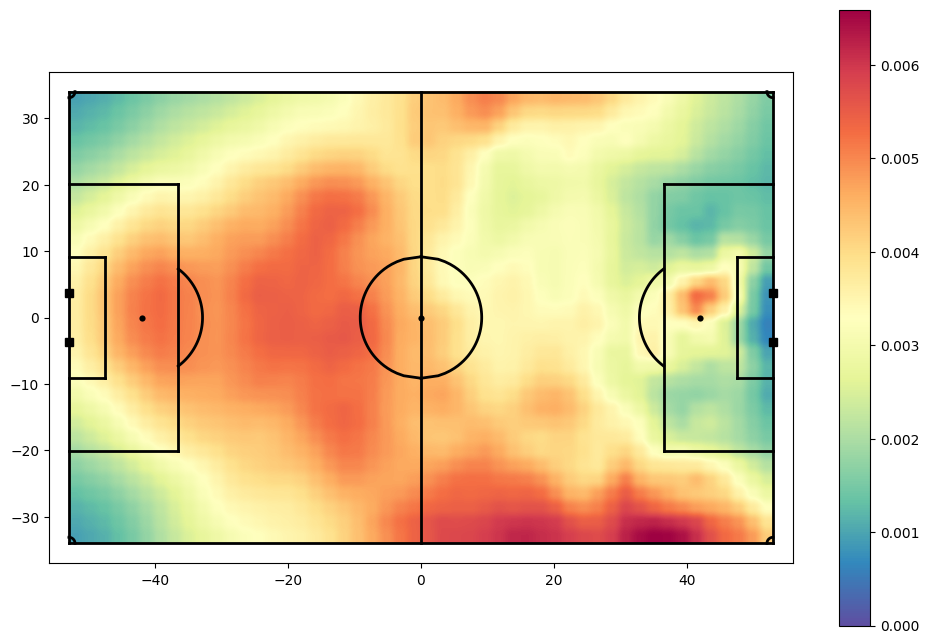

In [570]:
fig,ax = viz.plot_pitch(field_color='white', field_dimen = field_dimen)
im = ax.imshow(np.flipud(result), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,vmax=np.max(result),cmap="Spectral_r")
# Add colorbar
cbar = fig.colorbar(im)

CLUSTERING MATRIX INTO ZONAL THREATS

In [574]:
import numpy as np
from sklearn.cluster import KMeans

In [651]:
features = []
for matrix in control:
    features.append(matrix.flatten())

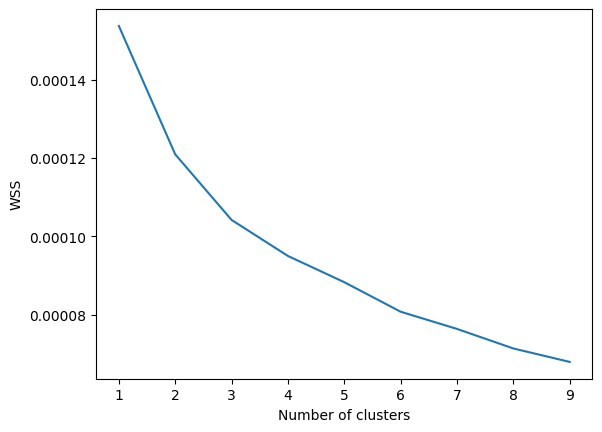

In [652]:
wss = []
max_clusters = 10
for i in range(1, max_clusters):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    wss.append(kmeans.inertia_)

import matplotlib.pyplot as plt
plt.plot(range(1, max_clusters), wss)
plt.xlabel('Number of clusters')
plt.ylabel('WSS')
plt.show()

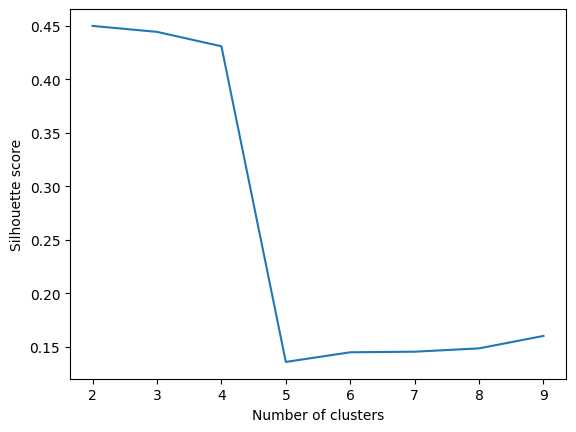

In [653]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
max_clusters = 10
for i in range(2, max_clusters):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

plt.plot(range(2, max_clusters), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [654]:
num_clusters = 4

In [655]:
X = np.array(features)
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)


In [656]:
cluster_labels = kmeans.labels_
clustered_matrices = [[] for i in range(num_clusters)]
for i, matrix in enumerate(control):
    clustered_matrices[cluster_labels[i]].append(matrix)


In [657]:
len(clustered_matrices)

4

In [675]:
result = np.zeros(clustered_matrices[0][0].shape)
for matrix in clustered_matrices[1]:
    result += matrix

In [676]:
len(clustered_matrices[1])

32

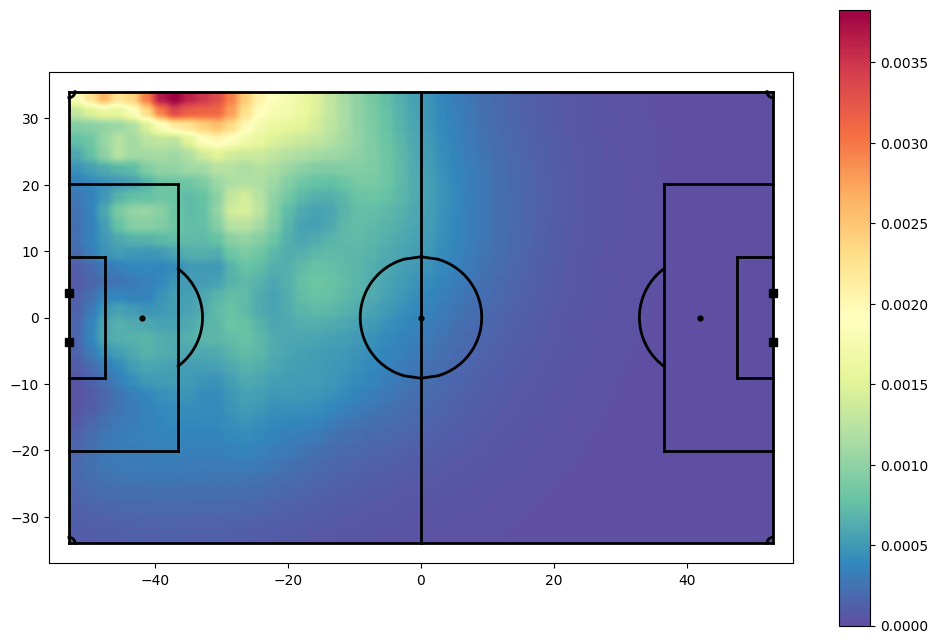

In [677]:
fig,ax = viz.plot_pitch(field_color='white', field_dimen = field_dimen)
im = ax.imshow(np.flipud(result), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,vmax=np.max(result),cmap="Spectral_r")
# Add colorbar
cbar = fig.colorbar(im)